In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
plt.style.use('dark_background')


### Grid Building

In [2]:
class Grid(object):
    def __init__(self, size):
        self.size = size
        self.grid = np.zeros((size, size), dtype=np.uint8)
        self.start_state = (0,0)
        self.goal_state = (size - 1, size - 1)
        self.grid[self.start_state[0]][self.start_state[1]] = 1
        
    
    def __str__(self):
        self.state = f""" Map State: \n {self.grid}
        """
        return self.state
    
    def __len__(self):
        return self.size
    
    def update_grid(self, position: tuple):
        if not self.is_allowed_action(position):
            return False
        else:
            x,y = position
            #count number of times in actions was taken. 
            self.grid[x][y] += 1
            return True
    
        
    def is_allowed_action(self,position: tuple):
        x, y = position
        return (x >= 0 and x < self.size) and (y >= 0 and y < self.size)
    

### Agent Building

In [3]:
class Agent(object):
    def __init__(self, current_state : Grid):
        self.current_state = current_state
        self.start_state = current_state.start_state
        self.goal_state = current_state.goal_state
        self.current_position = self.start_state
        #num_actions till goal.
        self.num_actions = 0
        self.logger = Logger()
    
    def __len__(self):
        """
        returns number of actions agent took until goal_state enviroment
        """
        return self.num_actions
    
    def __str__(self):
        """
        returns agents current enviroment
        """
        return str(self.current_state)
    
    def step(self, position: tuple):
        """
        returns True if it was sucessful move
        """
        if self.current_state.update_grid(position):
            self.current_position = position
            self.logger.add_move(position)
            return True
        else:
            return False
            

### Logger 

In [4]:
class Logger(object):
    def __init__(self):
        self.sequence_moves = []
        self.final_state = []
        
    def add_move(self, move: tuple):
        self.sequence_moves.append(move)
        
    def set_final_state(self, final_state: list[tuple]):
        self.final_state = final_state
        
    def get_log(self):
        return (self.final_state, np.array(self.sequence_moves))


### Algorithm Structure

In [5]:
class Algorithm(object):
    def __init__(self, agent : Agent):
        self.agent = agent
        self.algorithm_name = self.__class__.__name__
    def is_goal_state(self, position: tuple):
        if (position[0] == self.agent.goal_state[0] and position[1] == self.agent.goal_state[1]):
            self.agent.logger.set_final_state(self.agent.current_state)
            return True
        return False
            
    def get_possible_moves(self, position: tuple):
        x, y = position
        moves = []
        for i in range(2):
            for j in [-1,1]:
                if i == 0 and self.agent.current_state.is_allowed_action((x + j, y)):
                    moves.append((x + j, y))
                elif i == 1 and self.agent.current_state.is_allowed_action((x, y + j)):
                    moves.append((x, y + j))
                    
        return np.array(moves)
    
    def run(self):
        pass
    
    def print_message(self):
        pprint("Congratz you just won! ")
        pprint("Number of Moves: " + str(len(self.agent)))
        print(self.agent.current_state)

### Naive Algorithim 

In [6]:
import heapq
class Naive(Algorithm):
    def run(self):
        while not self.is_goal_state(self.agent.current_position):
            position = self.agent.current_position
            list_actions = self.get_possible_moves(position)
            move = list_actions[np.random.choice([i for i in range(len(list_actions))], size=1), :]
            if self.agent.step(move[0]):
                self.agent.num_actions += 1
            #print(self.agent.current_state)
                
        self.print_message()
    

### Priority Queue Algorithm using Manhattan Distance 

In [7]:
import heapq
class Heap(Algorithm):
    
    def __init__(self, agent : Agent):
        super().__init__(agent)
        self.distance_map = {}
        self.distance_traveled_map = {}
        pos = self.agent.start_state
        self.distance_map[pos] = self.man_dist(pos)
        
    def run(self):
        while not self.is_goal_state(self.agent.current_position):
            position = self.agent.current_position
            list_actions = self.get_possible_moves(position)
            delta = np.array([(self.man_dist(list_actions[i]), i) for i in range(len(list_actions))])
            moves = delta[delta[:, 0].argsort()]
            move_index = moves[0][1]
            move = list_actions[int(move_index),  :]
            if self.agent.step(move):
                self.agent.num_actions += 1
        self.print_message()
        
    def man_dist(self, pos):
        x, y = pos
        pos = (x,y)
        if pos in self.distance_map.keys():
            self.distance_traveled_map[pos] += self.distance_map[pos] 
        else:
            self.distance_traveled_map[pos] = np.sqrt((np.array(self.agent.goal_state) - np.array(pos))**2 @ np.array([1.0,1.0])) 
            self.distance_map[pos] = self.distance_traveled_map[pos]
        
        return self.distance_traveled_map[pos]

### Algorthims Factory

In [8]:
from enum import Enum
class Algorthims(Enum):
    naive = 'naive'
    heap = 'heap'
    
class AlgorithmFactory(object):
    def __init__(self, agent : Agent):
        self.agent = agent
    def get_instance(self, algorthimType : Algorthims):
        if algorthimType == Algorthims.naive:
            return Naive(self.agent)
        else:
            return Heap(self.agent)

### Simulation:

In [9]:
def simulate_experiment(grid_size : int, plot_sequence_moves=True):
    current_state_s = Grid(grid_size)
    current_state_r = Grid(grid_size)
    smart_agent = Agent(current_state_s)
    random_agent = Agent(current_state_r)

    naive = AlgorithmFactory(random_agent).get_instance(Algorthims.naive)
    heap = AlgorithmFactory(smart_agent).get_instance(Algorthims.heap)


    algorthims_list = [naive, heap]

    run_experiemnt(algorthims_list, plot_sequence_moves)
    

#### Running Experiment

In [10]:
def run_experiemnt(algorthims_list : list[Algorithm], plot_sequence_moves=True):
    for algorthim in algorthims_list:
        algorthim.run()
    plot_save_fig(algorthims_list)
    
    if plot_sequence_moves:
        plot_moves(algorthims_list)

#### Printing and Saving Heatmap

In [17]:
def plot_save_fig(algorthims_list : list[Algorithm]):
    for algorthim in algorthims_list:
        fig, ax = plt.subplots()
        im = ax.imshow(algorthim.agent.current_state.grid)
        plt.savefig(f"images/{algorthim.algorithm_name}.jpg")
        ax.set_title(f"{algorthim.algorithm_name} -- Heatmap")
        plt.show()

#### Plotting Sequence Moves 

In [18]:
def plot_moves(algorthims_list : list[Algorithm]):
    for algorthim in algorthims_list:
        V = algorthim.agent.logger.get_log()[1]
        origin = np.array([[0] * V.shape[0] ,[0] * V.shape[0]]) # origin point
        if algorthim.algorithm_name == 'Naive':
            plt.quiver(*origin, V[:,0], V[:,1] , scale = 4 ,color = ['b'])
        else:
            plt.quiver(*origin, V[:,0], V[:,1] ,scale = 4 ,color = ['g'])
        plt.suptitle(algorthim.algorithm_name, fontsize=  15)
        plt.grid(color = 'pink')
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        #start state
        plt.scatter(*(algorthim.agent.start_state), color='white', linewidths=5)
        #goal state
        plt.scatter(*(algorthim.agent.goal_state), color='yellow', linewidths=5)
        plt.show()

'Congratz you just won! '
'Number of Moves: 14'
 Map State: 
 [[1 1 1 0 0]
 [0 1 1 0 0]
 [0 2 1 2 1]
 [0 1 0 1 1]
 [0 0 0 0 1]]
        
'Congratz you just won! '
'Number of Moves: 8'
 Map State: 
 [[1 0 0 0 0]
 [1 1 0 0 0]
 [0 1 1 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
        


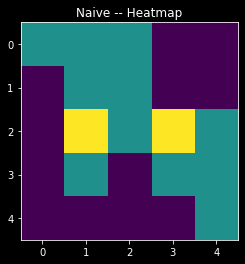

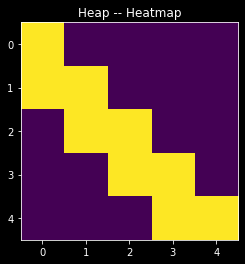

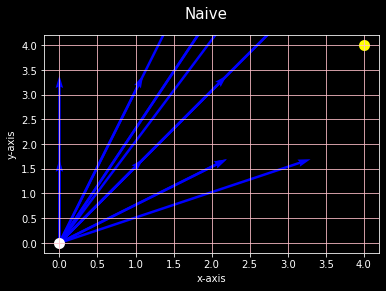

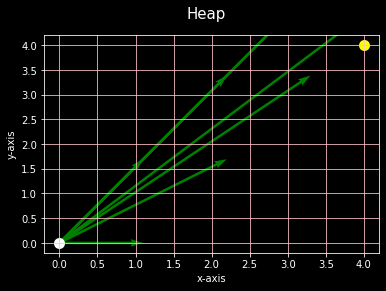

In [19]:
simulate_experiment(5)